In [1]:
import brightway2 as bw
import pandas as pd
import numpy as np
from constants import * #constants used in this project

# Choose a project and run LCI

In [2]:
bw.projects.set_current("SA")

In [3]:
bw.databases

Databases dictionary with 2 object(s):
	biosphere3
	ecoinvent 3.5 cutoff

In [4]:
db_name = 'ecoinvent 3.5 cutoff'
db = bw.Database(db_name)

In [5]:
act = db.random()
act_amount = 1.0 #unit demand vector
ipcc2013 = [m for m in bw.methods if 'IPCC' in m[0]
                        and ('2013') in str(m)
                        and 'GWP 100' in str(m)
                        and 'no LT' not in str(m)]
lca = bw.LCA({act:act_amount}, ipcc2013[0])
lca.lci()
lca.lcia()

# EET

## 1. create a vector tech_params identical to lca.tech_params but with an additional column for indices $1,2,...,n_{params}$ and dtype.name $i$

In [6]:
#augmented dtype
dt = lca.tech_params.dtype.descr
dt.insert(0,('i','<i4'))
dt = np.dtype(dt)

#number of parameters
n_params = lca.tech_params.shape[0]

In [7]:
#lca.tech_params augmented with the index on the first position
tech_params = np.zeros([n_params],dtype=dt)
i = 0
for x in lca.tech_params:
    temp = list(x)
    temp.insert(0,i)
    tech_params[i] = tuple(temp)
    i += 1

## 2. Generate samples for EET

### Generate uniformly distributed samples ($\in [0,1]$) using SALib

In [8]:
from SALib.sample import morris

In [9]:
import time 

sta = 50
end = 2000
ste = 50

t = np.zeros(int((end-sta)/ste)+1)
N = np.zeros(int((end-sta)/ste)+1)

i = 0
for n_par in range(sta,end,ste):
    
    #all uncertain parameters
    params = tech_params[tech_params['uncertainty_type']!=ID_NA][:n_par] #TODO change this eventually
    n_vars = len(params)
    names  = [str(x) for x in params['i']]
    bounds = np.array([np.zeros(n_vars),np.ones(n_vars)]).T #Always [0,1]!
    #samples info
    n_tra = 500          #number of trajectories
    p     = 4           #number of levels, even number recommended
    delta = p/(2*(p-1)) #grid jump recommended in papers
    #problem
    problem = {
        'num_vars':   n_vars,
        'num_levels': p,
        'names':      names,
        'bounds':     bounds,
    }

    print(i)
    
    tic = time.time()

    #Generate samples
    samples = morris.sample(problem, n_tra, num_levels=p)
    
    toc = time.time()
    
    N[i] = int(samples.shape[0])
    t[i] = toc-tic
    
    i += 1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38


In [ ]:
#Time scales linearly with the number of trajectories
import time 

sta = 500
end = 20000
ste = 500

t = np.zeros(int((end-sta)/ste)+1)
N = np.zeros(int((end-sta)/ste)+1)

i = 0
for n_tra in range(sta,end,ste):
    
    print(i)
    
    tic = time.time()

    #Generate samples
    samples = morris.sample(problem, n_tra, num_levels=p)
    
    toc = time.time()
    
    N[i] = int(samples.shape[0])
    t[i] = toc-tic
    
    i += 1
    
    

In [11]:
t

array([2.99939632e-01, 5.69345951e-01, 8.51902962e-01, 1.20645022e+00,
       1.65145278e+00, 2.21115899e+00, 3.09016204e+00, 4.15846610e+00,
       5.26036811e+00, 6.76961589e+00, 8.17101002e+00, 9.89374900e+00,
       1.19642889e+01, 1.46211979e+01, 1.78686378e+01, 2.11156790e+01,
       2.46726589e+01, 3.02375951e+01, 3.32233140e+01, 4.03374150e+01,
       5.23996041e+01, 5.76322081e+01, 6.93041611e+01, 7.39304280e+01,
       8.07093391e+01, 9.68665318e+01, 1.11357070e+02, 1.23217419e+02,
       1.40989750e+02, 1.37297113e+02, 1.78671569e+03, 1.69407805e+02,
       1.85177133e+02, 2.16038846e+02, 2.36710312e+02, 2.48934419e+02,
       3.24959857e+02, 3.41243938e+02, 3.68295468e+02, 0.00000000e+00])

In [12]:
N

array([ 25500.,  50500.,  75500., 100500., 125500., 150500., 175500.,
       200500., 225500., 250500., 275500., 300500., 325500., 350500.,
       375500., 400500., 425500., 450500., 475500., 500500., 525500.,
       550500., 575500., 600500., 625500., 650500., 675500., 700500.,
       725500., 750500., 775500., 800500., 825500., 850500., 875500.,
       900500., 925500., 950500., 975500.,      0.])

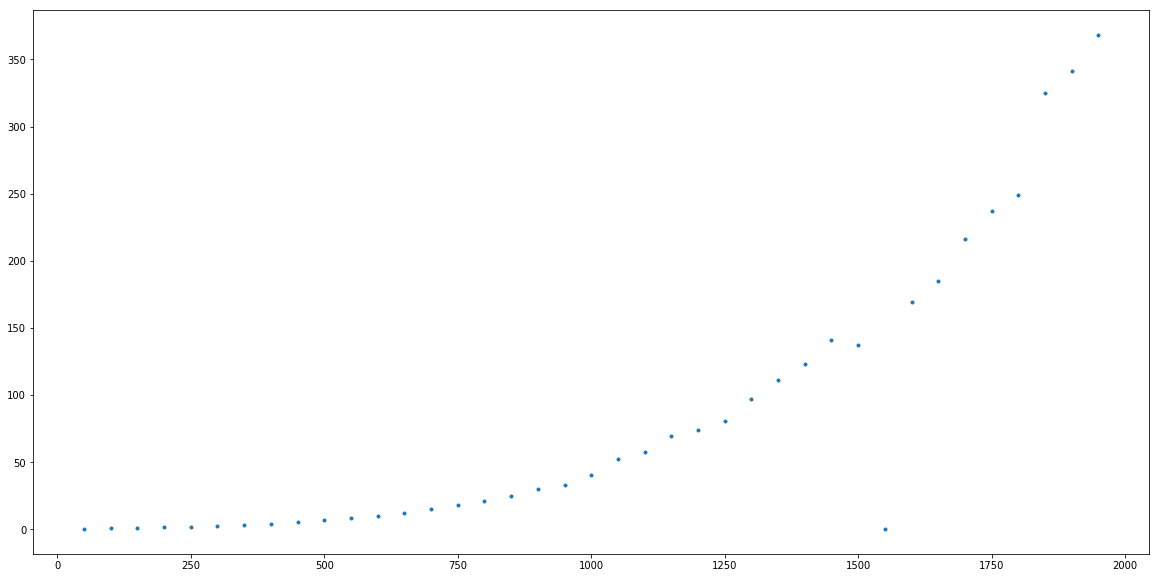

In [52]:
n_par = np.arange(sta,end,ste)

import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(n_par, t[:39], '.', label='time vs number of trajectories')
fig = plt.show()

In [139]:
t1

[0.2999396324157715,
 0.5693459510803223,
 0.851902961730957,
 1.2064502239227295,
 1.6514527797698975,
 2.2111589908599854,
 3.0901620388031006,
 4.158466100692749,
 5.26036810874939,
 6.769615888595581,
 8.17101001739502,
 9.893748998641968,
 11.96428894996643,
 14.621197938919067,
 17.868637800216675,
 21.115679025650024,
 24.672658920288086,
 30.237595081329346,
 33.22331404685974,
 40.33741497993469,
 52.399604082107544,
 57.63220810890198,
 69.30416107177734,
 73.93042802810669,
 80.7093391418457,
 96.86653184890747,
 111.35706996917725,
 123.21741890907288,
 140.98974990844727,
 137.29711294174194,
 150,
 169.4078049659729,
 185.17713284492493,
 216.0388457775116,
 236.71031188964844,
 248.93441891670227,
 324.9598569869995,
 341.24393820762634,
 368.2954680919647]

In [60]:
t1 = list(t[:len(t)-1])
n_par1 = list(n_par)

In [59]:
np.exp

<class 'numpy.ndarray'>


In [144]:
from scipy.optimize import curve_fit

def f(x, A, B,C): # this is your 'straight line' y=f(x)
    return A*x**B+C

A,B,C = curve_fit(f, n_par1, t1)[0] # your data x, y to fit
print(A)
print(B)
print(C)

8.682625279234881e-10
3.529745390789417
4.50001729009341


In [145]:
y = [f(xx,A,B,C) for xx in n_par1]

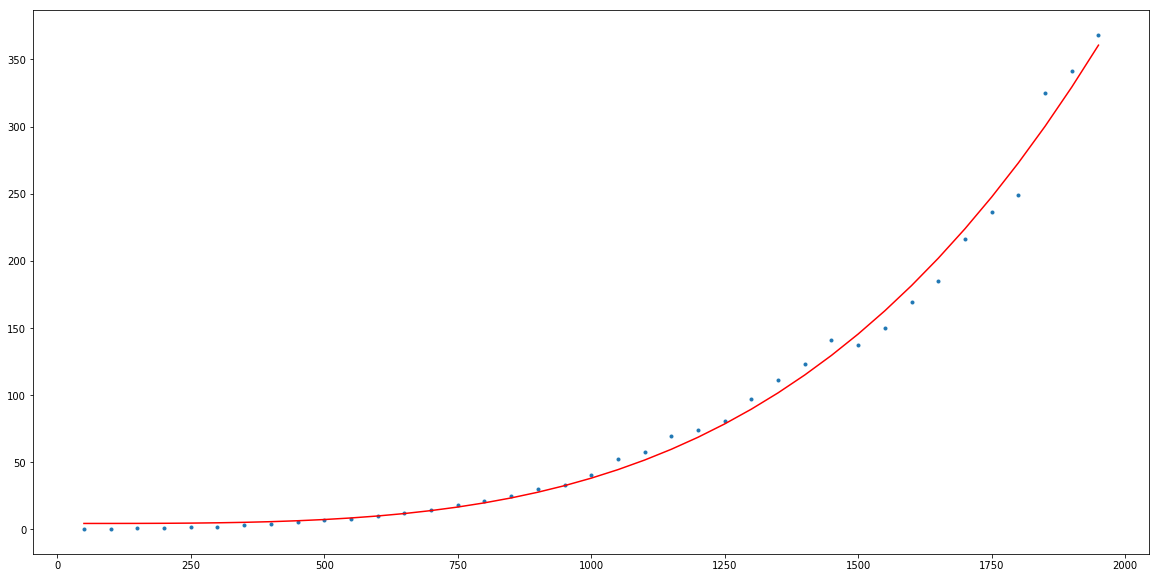

In [146]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(n_par, t1, '.', label='time vs number of trajectories')
plt.plot(n_par1, y, '-r', label='time vs number of trajectories')

plt.show()

In [133]:
t1[30] = 150

### Convert uniform samples to original distributions

In [ ]:
from scipy.stats import lognorm, norm, triang

In [ ]:
#give dtype with names to distinguish between input factors
data_type = [('<f4') for x in range(n_vars)]
dt = np.array([names,data_type]).T
dt = [tuple(x) for x in dt]
dt = np.dtype(dt)

samples_dt = np.zeros([N],dtype = dt)
i = 0
for x in samples:
    temp = list(x)
    samples_dt[i] = tuple(temp)
    i = i+1

In [ ]:
def obtain_original_pdf(problem,params,samples_uniform,id_distr):
    
    inds = params[params['uncertainty_type']==id_distr]['i']
    
    if len(inds)<=0:
        return np.zeros(0)
    
    else:
        
        #values corresponding to the chosen distribution
        names = [str(x) for x in inds]
        bounds = problem['bounds']
        p = problem['num_levels']
        
        #variable to save values of the converted distributions
        samples_conv = np.zeros_like(samples_uniform[names])
   
        #lognormal
        if id_distr == ID_LG: 
            
            #Quantiles are the same for all lognormal distributions given the level p
            q_lo = (1-SIX_SIGMA_Q)/2
            q_hi = (1+SIX_SIGMA_Q)/2
            q = np.linspace(q_lo,q_hi,p)
                        
            for name in names:
                
                x = samples_uniform[name]
                i = problem['names'].index(name)
                
                #new distribution
                #in bw:            loc=mu, scale=sigma, where mu and sigma are from the normal distribution
                #in stats.lognorm: loc=shift, s=sigma, scale=exp(mu), where mu and sigma are from the normal distribution 
                input_factor = params[params['i']==int(name)]
                mu = input_factor['loc']
                sigma  = input_factor['scale']
                shift = 0
                
                #generate unique converted values using ppf (=inverse of cdf)
                conv_unique = lognorm.ppf(q,s=sigma,loc=shift,scale=np.exp(mu))
                
                #save converted samples
                x_list = sorted(list(set(x)))
                for i in range(p):
                    samples_conv[name][x==[x_list[i]]] = conv_unique[i]
                                                                                    
        #normal
        elif id_distr == ID_NM:
            
            #Quantiles are the same for all normal distributions given the level p
            q_lo = (1-SIX_SIGMA_Q)/2
            q_hi = (1+SIX_SIGMA_Q)/2
            q = np.linspace(q_lo,q_hi,p)
            
            for name in names:
                
                x = samples_uniform[name]
                i = problem['names'].index(name)
                
                #new distribution
                #in bw:         loc=mu, scale=sigma, where mu and sigma are mean and std
                #in stats.norm: loc=mu, scale=sigma, where mu and sigma are mean and std 
                input_factor = params[params['i']==int(name)]
                mu = input_factor['loc']
                sigma  = input_factor['scale']
                
                #generate unique converted values using ppf (=inverse of cdf)
                conv_unique = norm.ppf(q,loc=mu,scale=sigma)
                
                #save converted samples
                x_list = sorted(list(set(x)))
                for i in range(p):
                    samples_conv[name][x==[x_list[i]]] = conv_unique[i]
                                
        #triangular
        elif id_distr == ID_TR:
            
            q = np.linspace(0,1,p)
            
            for name in names:
            
                x = samples_uniform[name]
                i = problem['names'].index(name)
                
                #new triangular distribution, convert loc, scale and c taken from "bw" to "stats.triang" definition
                #in bw:           input_factor (or params): 'minimum' < loc' < 'maximum'
                #in stats.triang: triangular distribution with an up-sloping line from loc to (loc + c*scale) 
                #                 and then downsloping for (loc + c*scale) to (loc+scale).
                input_factor = params[params['i']==int(name)]
                loc   = input_factor['minimum']
                scale = input_factor['maximum']-input_factor['minimum']
                c     = (input_factor['loc']-loc)/scale
                
                #generate unique converted values using ppf (=inverse of cdf)
                conv_unique = triang.ppf(q,c=c,loc=loc,scale=scale)
                
                #save converted samples
                x_list = sorted(list(set(x)))
                for i in range(p):
                    samples_conv[name][x==[x_list[i]]] = conv_unique[i]
                                    
        return samples_conv

In [ ]:
samples_lg = obtain_original_pdf(problem,params,samples_dt,ID_LG)
samples_nm = obtain_original_pdf(problem,params,samples_dt,ID_NM)
samples_tr = obtain_original_pdf(problem,params,samples_dt,ID_TR)

TODO

think about the computational effort
- how many calculations are needed for a reasonable result?
- how much time is it?

optimize code, only a few levels are used so no need to run ppf all the time

combine samples together and run morris.analyze


### Run Morris

#### Simple 2 variable example to check distributions

In [ ]:
from SALib.sample import morris
from scipy.stats import lognorm, norm, triang
import numpy as np
import matplotlib.pyplot as plt
from constants import *

In [ ]:
n_vars = 2
names = ['x1','x2']
bounds = [[0,1],[0,7]]
problem = {
    'num_vars': n_vars,
    'names':    names,
    'bounds':   bounds
}
n_tra = 1000
p = 1000
samples = morris.sample(problem, N=n_tra, num_levels=p)
N = samples.shape

In [ ]:
ind = 1
x = samples[:,ind]
#old uniform distribution
width = bounds[ind][1]-bounds[ind][0]

In [ ]:
set(x)

In [ ]:
#1. Lognormal

#convert x to percentages q
q = [xx*SIX_SIGMA_Q/width+(1-SIX_SIGMA_Q)/2 for xx in x]
#new lognormal
mu = 0
sigma = 0.5
shift = 0
#Converted samples generated using ppf (=inverse of cdf)
y = lognorm.ppf(q,s=sigma,loc=shift,scale=np.exp(mu))

fig = plt.hist(y,50)

In [ ]:
#2. Normal
#convert x to percentages q
q = [xx*SIX_SIGMA_Q/width+(1-SIX_SIGMA_Q)/2 for xx in x]
#ql = 0.0015
#qu = 0.9985
#q = [max(qq,ql) for qq in q]
#q = [min(qq,qu) for qq in q]
#new normal
mu = 0
sigma = 0.5 
#Converted samples generated using ppf (=inverse of cdf)
y = norm.ppf(q,loc=mu,scale=sigma)

fig = plt.hist(y,150,density=1)

In [ ]:
#3. Triangular
#convert x to percentages q
q = [xx/width for xx in x]
#new triangular
loc   = 0.01
scale = 0.11
c     = 0.9
#Converted samples generated using ppf (=inverse of cdf)
y = triang.ppf(q,c=c,loc=loc,scale=scale)

fig = plt.hist(y,150,density=1)

In [ ]:
from scipy.integrate import quad
from math import pi, exp, log
from scipy.stats import norm, triang, lognorm
import matplotlib.pyplot as plt

In [ ]:
#TODO determine 6 sigma for lognormal
s = 1
m = 0
#quad(lambda x: 1/np.sqrt(2*pi*s**2)*exp(-(x-m)**2/(2*s**2)),-3*s, 3*s)
quad(lambda x: 1/np.sqrt(2*pi*(s**2)*(x**2))*exp(-(log(x)-m)**2/(2*(s**2))),0,4*s)

In [ ]:
fig, ax = plt.subplots(1, 1)
x = samples_dt['19640']
c = 0.8
loc = 0
scale = 1
ax.plot(x, norm.pdf(x),'r-', lw=5, alpha=0.6, label='triang pdf')
plt.show()

## 3. Run LCI and LCIA with tech_params with new samples

In [ ]:
#Create new vector "amounts" of size n_params but with new sampled values
amount = lca.tech_params['amount']
score = np.zeros(N)
i = 0
for x in samples:
    if not (i % 50):
        print(i)
    amount[all_triang['i']] = x
    lca.tech_params['amount'] = amount
    lca.rebuild_technosphere_matrix(lca.tech_params['amount'])
    lca.redo_lci()
    lca.redo_lcia()
    score[i] = lca.score
    i += 1

In [ ]:
#Create new vector "amounts" of size n_params but with new sampled values
amount = lca.tech_params['amount']
score = np.zeros(N)
i = 0
amount[all_triang['i']] = samples[90]
lca.tech_params['amount'] = amount
lca.rebuild_technosphere_matrix(lca.tech_params['amount'])
lca.redo_lci()
lca.redo_lcia()
#score[i] = lca.score
#i += 1
lca.score

In [ ]:
samples[90]

In [ ]:
from scipy.stats.distributions import norm

In [ ]:
norm?

In [ ]:
score

In [ ]:
from matplotlib.pyplot import hist

In [ ]:
hist()

# [12.10.2018] Elementary effect method

In [ ]:
Si = morris.analyze(problem, X, Y, conf_level=0.95, print_to_console=True, num_levels=4, grid_jump=2)

In [ ]:
uncertain_params = lca.tech_params

def formulate_salib_problem(uncertain_params):
    
    stats_array_2_salib(uncertain_params)
    
    num_vars = len(uncertain_params)
    
    #Assign names to all tech_params according to their matrix position
    names = [str(x) for x in range(num_vars)]
    
    bounds = []
    
    return num_vars, names, bounds

In [ ]:
from math import exp, sqrt

In [ ]:
def stats_array_2_salib(vec):
    """
    Function that converts uncertainty info from stats_array format to salib format
    
    stats_array format: https://stats-arrays.readthedocs.io/en/latest/index.html#params-array
    salib format: https://github.com/SALib/SALib/blob/master/SALib/util/__init__.py
    """
    
    #IDs from stats_array
    id_uniform = 4
    id_triang = 5
    id_normal = 3
    id_lognorm = 2
    
    #Uniform
    if vec['uncertainty_type'] == id_uniform:
        dists = ['unif', vec['minimum'], vec['maximum']]
    #Triangular
    elif vec['uncertainty_type'] == id_triang:
        width = vec['maximum']-vec['minimum']
        peak = (vec['loc']-vec['minimum'])/float(width)
        dists = ['triang', width, peak, vec['minimum']]
    #Normal
    elif vec['uncertainty_type'] == id_normal:
        dists = ['norm', vec['loc'], vec['scale']]
    #Lognormal
    elif ['uncertainty_type'] == id_lognorm:
        m = vec['loc']   #mean of the underlying normal distribution
        s = vec['scale'] #std  of the underlying normal distribution
        ln_mean = exp(m + s**2/2)
        ln_std = sqrt((exp(s**2)-1)*exp(2*m+s**2))
        dists = ['lognorm', ln_mean, ln_std]
    else:
        dists = []
        
    return dists
    

In [ ]:
def stats_array_2_salib_all(vecs):
    for x in vecs:
        #Create a dictionary with tech_params and uncertainty info on them
        if x[6] ~= 0:
            

In [ ]:
stats_array_2_salib(lca.tech_params[16026])

In [ ]:
s = 0
for i in range(lca.tech_params.shape[0]):
    #Create a dictionary with tech_params and uncertainty info on them
    if lca.tech_params[i][5] == 5:
        s+=1
print(s)

In [ ]:
lca.tech_params[16026][]

# For the given demand vector run Monte Carlo simulations

In [ ]:
import stats_arrays as st

In [ ]:
#First local MC, only change A[1,2681]
for j in range(len(act_lci.tech_params)):
    if ((act_lci.tech_params[j]["row"]==1) and (act_lci.tech_params[j]["col"]==2681)):
        break
index = j
A_1_2681 = act_lci.tech_params[index]
#Specify distribution parameters (as they are given by ecoinvent)
A_1_2681_params = {key:value for (key,value) in zip(A_1_2681.dtype.names,A_1_2681)}

In [ ]:
#random number generator
A_1_2681_gen = st.MCRandomNumberGenerator(st.UncertaintyBase.from_dicts(A_1_2681_params))

In [ ]:
#number of MC simulations
N = 10
samples = np.zeros(N)
supply  = np.zeros((N,act_lci.inventory.shape[0]))
for i in range(N):
    samples[i] = next(A_1_2681_gen)
    temp = copy.deepcopy(act_lci.tech_params[:]["amount"])
    temp[index] = samples[i]
    act_lci.rebuild_technosphere_matrix(temp)
    act_lci.redo_lci()
    supply[i,:] = np.sum(act_lci.inventory,axis=1).A1

In [ ]:
#First order sensitivity indices
si_first = np.var(samples)/np.var(supply)
#si_total = 